In [1]:
# Importa as bibliotecas necessárias
%run '~/git/Bibliotecas.ipynb'

### 1.Fertilizantes  

O foco do projeto são as importações através das Unidades da Receita Federal, consequentemente através dos portos de Salvador e Aratu na Bahia e destinadas a empresas importadoras sediadas nesta mesma Unidade Federativa.

In [2]:
urf=pd.read_csv('~/git/BD/Comexstat/URF.csv',encoding='Latin-1',sep=';')
urf_salvador_aratu=urf[(urf.NO_URF.str.contains('ARATU'))|(urf.NO_URF.str.contains('SALVADOR'))].CO_URF
urf_salvador_aratu

47     517600
64     517700
65     517602
157    510100
162    517800
163    517801
Name: CO_URF, dtype: int64

In [3]:
i=pd.read_csv('~/git/Pricing-Fertilizer-take-Rains-into-account/temp/imp1.csv')
i=i[(i.CO_URF.isin(urf_salvador_aratu))&(i.SG_UF_NCM=='BA')]
i.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
25,1997,1,31042090,10,23,BA,1,517600,59,59400,10128,5824,41
84,1997,2,31043010,10,383,BA,1,517600,63,62950,25180,4950,0
116,1997,3,31022100,10,249,BA,1,510100,4003056,4003056,385794,72000,1574
117,1997,3,31022100,10,249,BA,1,517600,2000000,2001528,194148,36000,1393
132,1997,3,31029000,10,383,BA,1,517600,21300,21300,8658,1475,0


Como a coluna SG_UF_NCM ficou apenas com uma única categoria, 'BA', e como não há perspectiva de aproveitar a informação sobre unidade de  Receita Federal, essas duas colunas serão descartadas.

In [4]:
i.groupby('CO_VIA')['KG_LIQUIDO'].sum().sort_values()

CO_VIA
4            201
1    22033169330
Name: KG_LIQUIDO, dtype: int64

In [5]:
i.groupby('CO_UNID')['KG_LIQUIDO'].sum().sort_values()

CO_UNID
10    22033169531
Name: KG_LIQUIDO, dtype: int64

Como as colunas 'CO_VIA' e 'CO_UNID' apresentam praticamente todos os  es em uma única categoria, elas serão também  descartadas.

A coluna 'QT_STAT' representa a quantidade importada medidas em outras unidades de que não sejam o 'KG_LIQUIDO'. Isso não é de interesse do projeto e a coluna também será descartada.

In [6]:
i.drop(columns=['SG_UF_NCM','CO_URF','CO_UNID','CO_VIA','QT_ESTAT'], inplace=True)

In [7]:
i.head()

,CO_ANO,CO_MES,CO_NCM,CO_PAIS,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
25,1997,1,31042090,23,59400,10128,5824,41
84,1997,2,31043010,383,62950,25180,4950,0
116,1997,3,31022100,249,4003056,385794,72000,1574
117,1997,3,31022100,249,2001528,194148,36000,1393
132,1997,3,31029000,383,21300,8658,1475,0


In [8]:
i.duplicated().sum()

0

In [9]:
i.isna().sum()

CO_ANO        0
CO_MES        0
CO_NCM        0
CO_PAIS       0
KG_LIQUIDO    0
VL_FOB        0
VL_FRETE      0
VL_SEGURO     0
dtype: int64

O arquivo não contém duplicatas nem celulas vazias ou inválidas.

In [10]:
i[i.KG_LIQUIDO<=0]

,CO_ANO,CO_MES,CO_NCM,CO_PAIS,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO
10049,2002,4,31042090,767,0,70,0,0
15426,2004,5,31042090,249,0,230,8,0


In [11]:
i[i.VL_FOB<=0]

,CO_ANO,CO_MES,CO_NCM,CO_PAIS,KG_LIQUIDO,VL_FOB,VL_FRETE,VL_SEGURO


O arquivo possui dois registros sem peso maior que zero. Estes mesmos registros apresentam   FOB irrisório e por isso serão descatados.

In [12]:
i=i[i.KG_LIQUIDO>0]

Numa primeira tentativa de atingir o objetivo, não levaremos em análise os diferentes NCMs e países de origem do registro de importação. Assim, a coluna 'CO_NCM' e 'CO_PAIS' serão descrtadas e os  es agrupados. Os  es monetários também serao descartados.

In [13]:
i=i.groupby(by=['CO_ANO','CO_MES'])['KG_LIQUIDO'].sum().reset_index()

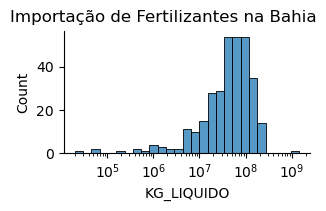

In [14]:
g=sns.displot(height=2, aspect=1.618,data=i,x='KG_LIQUIDO',log_scale=True)
g.fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

Os  es menores do que 10**6.3 serão descartados.

In [15]:
i=i[i.KG_LIQUIDO>10**6.3]

Um registro apresenta peso muito acima da normalidade.

In [16]:
i[i.KG_LIQUIDO==i.KG_LIQUIDO.max()]

,CO_ANO,CO_MES,KG_LIQUIDO
78,2003,8,1420253045


Ele será substituido pela interpolação dos  es do mês no ano anterior e posterior ao ocorrido.

In [17]:
ano_erro=i[i.KG_LIQUIDO==i.KG_LIQUIDO.max()].CO_ANO.values[0]

ano_corr_anterior=i[i.CO_ANO==ano_erro+1].CO_ANO.values[0]

ano_corr_posterior=i[i.CO_ANO==ano_erro-1].CO_ANO.values[0]

mes_erro=i[i.KG_LIQUIDO==i.KG_LIQUIDO.max()].CO_MES.values[0]

val_corr=i[i.CO_ANO.isin([ano_corr_anterior,ano_corr_posterior])].KG_LIQUIDO.mean()

i.loc[i.KG_LIQUIDO==i.KG_LIQUIDO.max(),'KG_LIQUIDO']=val_corr

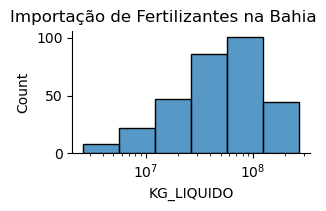

In [18]:
sns.displot(height=2, aspect=1.618,data=i,x='KG_LIQUIDO',log_scale=True, bins=6).fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
plt.show()

In [19]:
i['date']=pd.to_datetime(i.CO_ANO.astype(str)+'/'+i.CO_MES.astype(str)+'/1')

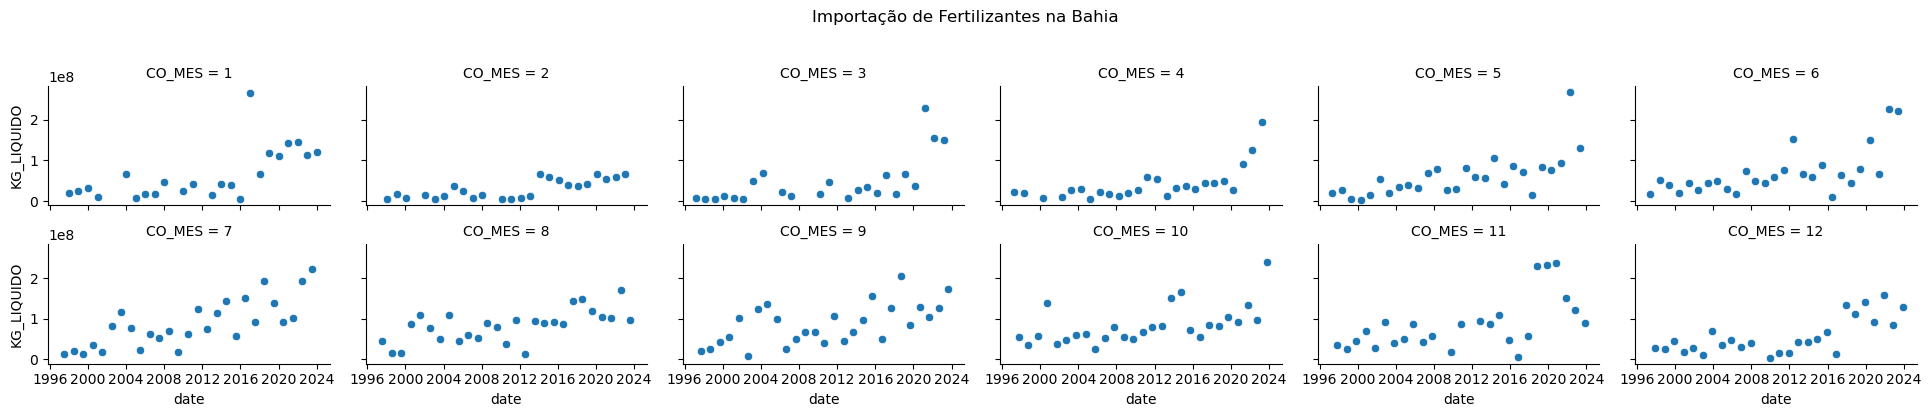

In [20]:
g=sns.relplot(height=2, aspect=1.618,data=i,x='date',y='KG_LIQUIDO',col='CO_MES',col_wrap=6)
g.fig.suptitle('Importação de Fertilizantes na Bahia',y=1.1)
#g.set_xticklabels(rotation=90)
plt.tight_layout()

In [21]:
# Martiz Esparsa
i_ini=i.date.min()
i_fim=i.date.max()
i[['CO_ANO','CO_MES']]=i[['CO_ANO','CO_MES']].astype('category')
i2=i.groupby(by=['CO_ANO','CO_MES']).KG_LIQUIDO.sum().reset_index()
i2['date']=pd.to_datetime(i2.CO_ANO.astype(str)+'/'+i2.CO_MES.astype(str)+'/1')
i2=i2[(i2.date>=i_ini)&(i2.date<=i_fim)]
i2

,CO_ANO,CO_MES,KG_LIQUIDO,date
2,1997,3,7505776.0,1997-03-01
3,1997,4,22660177.0,1997-04-01
4,1997,5,19598019.0,1997-05-01
5,1997,6,17594350.0,1997-06-01
6,1997,7,14261348.0,1997-07-01
...,...,...,...,...
320,2023,9,172570477.0,2023-09-01
321,2023,10,240914358.0,2023-10-01
322,2023,11,90119779.0,2023-11-01
323,2023,12,128496690.0,2023-12-01


In [22]:
i2['KG_fit']=np.poly1d(np.polyfit(i2.date.astype(int),i2.KG_LIQUIDO, deg=4))(i2.date.astype(int))
i2['KG_resi']=i2.KG_LIQUIDO-i2.KG_fit
i2

,CO_ANO,CO_MES,KG_LIQUIDO,date,KG_fit,KG_resi
2,1997,3,7505776.0,1997-03-01,1.462578e+07,-7.120007e+06
3,1997,4,22660177.0,1997-04-01,1.549142e+07,7.168761e+06
4,1997,5,19598019.0,1997-05-01,1.631067e+07,3.287345e+06
5,1997,6,17594350.0,1997-06-01,1.713843e+07,4.559245e+05
6,1997,7,14261348.0,1997-07-01,1.792151e+07,-3.660159e+06
...,...,...,...,...,...,...
320,2023,9,172570477.0,2023-09-01,1.533193e+08,1.925122e+07
321,2023,10,240914358.0,2023-10-01,1.543412e+08,8.657314e+07
322,2023,11,90119779.0,2023-11-01,1.553975e+08,-6.527774e+07
323,2023,12,128496690.0,2023-12-01,1.564199e+08,-2.792319e+07


In [23]:
i3=pd.concat([
    i2[['date','KG_LIQUIDO']].assign(tipo='real'   ).rename(columns={'KG_LIQUIDO':'KG'}),
    i2[['date','KG_fit'    ]].assign(tipo='regress').rename(columns={'KG_fit'    :'KG'})
    ])
i3

,date,KG,tipo
2,1997-03-01,7.505776e+06,real
3,1997-04-01,2.266018e+07,real
4,1997-05-01,1.959802e+07,real
5,1997-06-01,1.759435e+07,real
6,1997-07-01,1.426135e+07,real
...,...,...,...
320,2023-09-01,1.533193e+08,regress
321,2023-10-01,1.543412e+08,regress
322,2023-11-01,1.553975e+08,regress
323,2023-12-01,1.564199e+08,regress


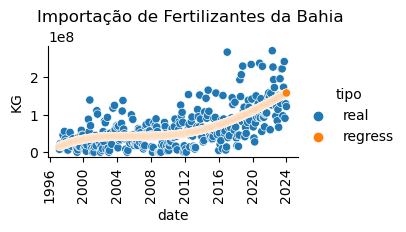

In [24]:
sns.relplot(height=2, aspect=1.618,data=i3,x='date',y='KG',hue='tipo').fig.suptitle('Importação de Fertilizantes da Bahia',y=1.1)
plt.xticks(rotation=90)
plt.show()

In [25]:
i2

,CO_ANO,CO_MES,KG_LIQUIDO,date,KG_fit,KG_resi
2,1997,3,7505776.0,1997-03-01,1.462578e+07,-7.120007e+06
3,1997,4,22660177.0,1997-04-01,1.549142e+07,7.168761e+06
4,1997,5,19598019.0,1997-05-01,1.631067e+07,3.287345e+06
5,1997,6,17594350.0,1997-06-01,1.713843e+07,4.559245e+05
6,1997,7,14261348.0,1997-07-01,1.792151e+07,-3.660159e+06
...,...,...,...,...,...,...
320,2023,9,172570477.0,2023-09-01,1.533193e+08,1.925122e+07
321,2023,10,240914358.0,2023-10-01,1.543412e+08,8.657314e+07
322,2023,11,90119779.0,2023-11-01,1.553975e+08,-6.527774e+07
323,2023,12,128496690.0,2023-12-01,1.564199e+08,-2.792319e+07


In [26]:
i=i2

### 2.Chuvas

In [27]:
# Importa as bibliotecas necessárias
%run '~/git/Bibliotecas.ipynb'

In [28]:
c=pd.read_csv('/home/andre301267/git/Pricing-Fertilizer-take-Rains-into-account/temp/chuvas1.csv')

In [29]:
c=c[c.columns[[20,0,21,1,22,2]]]
c.columns=['Estação','date1','date2','hora1','hora2','mm']
c.date1=pd.to_datetime(c.date1+'-'+c.hora1)
c.date2=pd.to_datetime(c.date2+'-'+c.hora2)
c['date']=pd.to_datetime(pd.concat([c.date1.dropna(),c.date2.dropna()]), utc=True)
c['CO_ANO']=c.date.dt.year
c['CO_MES']=c.date.dt.month
c['Dia']=c.date.dt.day
c['Hora']=c.date.dt.hour
c.head(1)

,Estação,date1,date2,hora1,hora2,mm,date,CO_ANO,CO_MES,Dia,Hora
0,BARREIRAS,2002-01-01,NaT,00:00,NaN,0,2002-01-01 00:00:00+00:00,2002,1,1,0


In [30]:
cc=c.copy()

# ATENÇÃO

In [31]:
c=cc.copy()

In [32]:
c=c[c.columns[[0,6,7,8,9,10,5]]]

In [33]:
c.loc[c.mm=='-9999','mm']=np.nan
c.mm=c.mm.str.replace(',','.')
c.mm=c.mm.astype('float')

In [34]:
c.duplicated().sum()

0

In [35]:
c.isna().sum()

Estação         0
date            0
CO_ANO          0
CO_MES          0
Dia             0
Hora            0
mm         103001
dtype: int64

In [36]:
c_na=c[(c.mm.isna())]
c_not_na=c[~(c.mm.isna())]

In [37]:
print(f"O número de registros sem   em 'mm' corresponde a {round(100*len(c_na)/len(c))} % do total")

O número de registros sem valor em 'mm' corresponde a 19 % do total


In [38]:
c_na.isna().sum()

Estação         0
date            0
CO_ANO          0
CO_MES          0
Dia             0
Hora            0
mm         103001
dtype: int64



4 % das horas registradas apresentam falhas na marcação do volume de chuva em 'mm'.


                  Horas com Falha no Registro de Chuvas





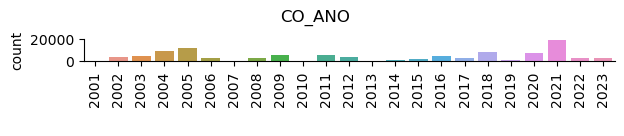

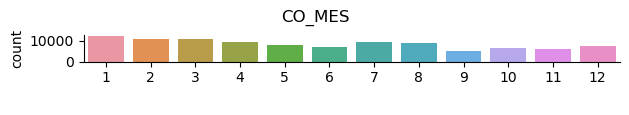

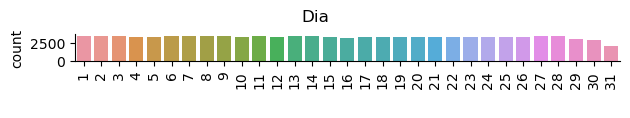

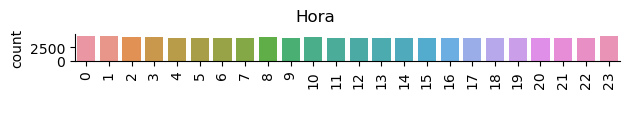

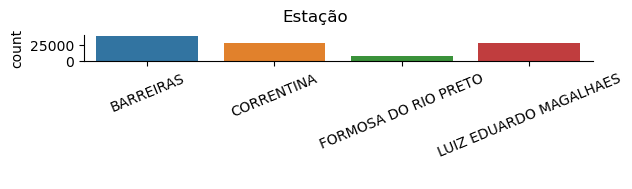


Conclsão: As falhas no registro de chuva aparentam estar normalmente distribuidas em todas as categorias.






In [210]:
w=pd.concat([\
c_na.groupby('CO_ANO' ).CO_MES.count().reset_index().rename(columns={'CO_MES':'count','CO_ANO':' '}).assign(tipo='CO_ANO' ),
c_na.groupby('CO_MES' ).CO_ANO.count().reset_index().rename(columns={'CO_ANO':'count','CO_MES':' '}).assign(tipo='CO_MES' ),
c_na.groupby('Dia'    ).CO_ANO.count().reset_index().rename(columns={'CO_ANO':'count','Dia':' '}).assign(tipo='Dia'    ),
c_na.groupby('Hora'   ).CO_ANO.count().reset_index().rename(columns={'CO_ANO':'count','Hora':' '}).assign(tipo='Hora'   ),
c_na.groupby('Estação').CO_ANO.count().reset_index().rename(columns={'CO_ANO':'count','Estação':' '}).assign(tipo='Estação')])

for t in w.tipo.unique():
    w_t=w[w.tipo==t]
    sns.catplot(height=1,aspect=4*1.6,data=w_t,x=' ',y='count',kind='bar').fig.suptitle(t,y=1.1)
    plt.xticks(rotation=90)
    if t =='Estação':
        plt.xticks(rotation=22.5)
    elif t=='CO_MES':
        plt.xticks(rotation=0)
print(f"\n\n{round(100*len(c_not_na[c_not_na.mm!=0])/len(c_not_na))} % das horas registradas apresentam falhas na marcação do volume de chuva em 'mm'.")
print('\n\n                  Horas com Falha no Registro de Chuvas\n\n\n')
plt.show()

print('\nConclsão: As falhas no registro de chuva aparentam estar normalmente distribuidas em todas as categorias.\n\n\n\n')

In [226]:
c_not_na['mm_hora_log']=np.log10(c_not_na.mm)

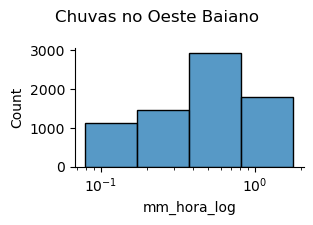

In [228]:
sns.displot(height=2, aspect=1.618,data=c_not_na[c_not_na.mm_hora_log!=0],x='mm_hora_log',log_scale=True, bins=4).fig.suptitle('Chuvas no Oeste Baiano',y=1.1)
plt.show()

In [45]:
c_dia=c_not_na.groupby(by=c_not_na.columns[[0,1,2,3,4]].tolist())[['mm']].sum().reset_index()
c_dia.head(1)

,Estação,date,CO_ANO,CO_MES,Dia,mm
0,BARREIRAS,2001-12-20 15:00:00+00:00,2001,12,20,2.0


In [229]:
c_dia['mm_dia_log']=np.log10(c_dia.mm)

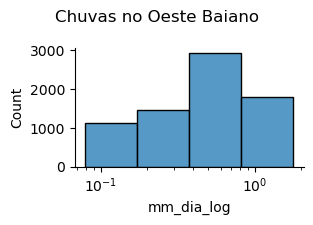

In [230]:
sns.displot(height=2, aspect=1.618,data=c_dia[c_dia.mm_dia_log!=0],x='mm_dia_log',log_scale=True, bins=4).fig.suptitle('Chuvas no Oeste Baiano',y=1.1)
plt.show()

>Note que, nos gráficos acima, devido a grande amplitude nos volumes de chuvas registrados, para possibilitar a visualização da curva normal foi necessário aplicar duplo logarítmo: primeiro transformando diretamente o valor medido para logarítmo e, o segundo, utilizando escala logarítmica na hora de plotar o gráfico.

In [241]:
c_mes=c_dia.groupby(by=['Estação','CO_ANO','CO_MES']).mm.sum().reset_index().rename(columns={'mm':'mm_mes'})

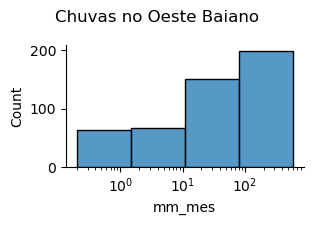

In [250]:
sns.displot(height=2, aspect=1.618,data=c_mes[c_mes.mm_mes!=0],x='mm_mes',log_scale=True, bins=4).fig.suptitle('Chuvas no Oeste Baiano',y=1.1)
plt.show()

Juntando os dados das estações meteorológicas em uma tabela somente, utilizando os valores da mediana.

In [254]:
c=c_mes.groupby(by=['CO_ANO','CO_MES']).mm_mes.median().reset_index()

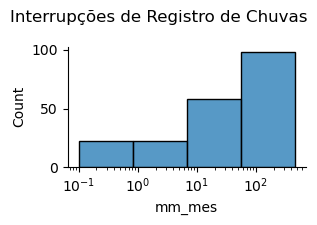

In [255]:
sns.displot(height=2, aspect=1.618,data=c[c.mm_mes!=0],x='mm_mes',log_scale=True,bins=4).fig.suptitle('Interrupções de Registro de Chuvas',y=1.1)
plt.show()

In [256]:
c['date']=pd.to_datetime(c.CO_ANO.astype(str)+'/'+c.CO_MES.astype(str)+'/1')
c

,CO_ANO,CO_MES,mm_mes,date
0,2001,12,23.2,2001-12-01
1,2002,1,0.0,2002-01-01
2,2002,2,0.0,2002-02-01
3,2002,3,28.0,2002-03-01
4,2002,4,17.8,2002-04-01
...,...,...,...,...
255,2023,8,14.8,2023-08-01
256,2023,9,0.8,2023-09-01
257,2023,10,38.7,2023-10-01
258,2023,11,39.8,2023-11-01


In [257]:
c_ini=c.date.iloc[0]
c_fim=c.date.iloc[-1]

In [259]:
# Matriz Esparsa
c[['CO_ANO','CO_MES']]=c[['CO_ANO','CO_MES']].astype('category')
c=c.groupby(by=['CO_ANO','CO_MES']).mm_mes.sum().reset_index()
c[['CO_ANO','CO_MES']]=c[['CO_ANO','CO_MES']].astype('int')
c['date']=pd.to_datetime(c.CO_ANO.astype(str)+'/'+c.CO_MES.astype(str)+'/1')
c=c[(c.date>=c_ini)&(c.date<=c_fim)]

In [262]:
c['date']=pd.to_datetime(c.CO_ANO.astype(str)+'/'+c.CO_MES.astype(str)+'/1')
c=c.rename(columns={'mm_mes':'mm'})
c

,CO_ANO,CO_MES,mm,date
11,2001,12,23.2,2001-12-01
12,2002,1,0.0,2002-01-01
13,2002,2,0.0,2002-02-01
14,2002,3,28.0,2002-03-01
15,2002,4,17.8,2002-04-01
...,...,...,...,...
271,2023,8,14.8,2023-08-01
272,2023,9,0.8,2023-09-01
273,2023,10,38.7,2023-10-01
274,2023,11,39.8,2023-11-01


In [263]:
c=c.sort_values(by=['CO_ANO','CO_MES'])

# Junta imp com chuvas

In [265]:
i1=i.copy()
c1=c.copy()

In [266]:
i=i1.copy()
c=c1.copy()

In [267]:
i.columns

Index(['CO_ANO', 'CO_MES', 'KG_LIQUIDO', 'date', 'KG_fit', 'KG_resi'], dtype='object')

In [268]:
c.columns

Index(['CO_ANO', 'CO_MES', 'mm', 'date', 'mm_log'], dtype='object')

In [269]:
i_c=i.merge(c)

from sklearn.preprocessing import MinMaxScaler as mms
mms=mms()
i_c_mms=pd.DataFrame(mms.fit_transform(i_c[['KG_resi','mm','mm_log']]))
i_c_mms.columns=['kg_resi_mms','mm_mms','mm_log_mms']
i_c=pd.concat([i_c,i_c_mms],axis=1)
i_c.head(1)

,CO_ANO,CO_MES,KG_LIQUIDO,date,KG_fit,KG_resi,mm,mm_log,kg_resi_mms,mm_mms,mm_log_mms
0,2001,12,28011377.0,2001-12-01,3.995738e+07,-1.194601e+07,23.2,1.365488,0.270018,0.051056,0.646761


In [270]:
# Médias
kg_resi_m = i_c.groupby('CO_MES').kg_resi_mms.mean().reset_index().rename(columns={'kg_resi_mms':'kg_resi_mms_mean'})
mm_m      = i_c.groupby('CO_MES').mm_mms     .mean().reset_index().rename(columns={'mm_mms'     :'mm_mms_mean'     })
mm_log_m  = i_c.groupby('CO_MES').mm_log_mms .mean().reset_index().rename(columns={'mm_log_mms' :'mm_log_mms_mean' })

i_c=i_c.merge(kg_resi_m).merge(mm_m).merge(mm_log_m)
i_c.head(1)

,CO_ANO,CO_MES,KG_LIQUIDO,date,KG_fit,KG_resi,mm,mm_log,kg_resi_mms,mm_mms,mm_log_mms,kg_resi_mms_mean,mm_mms_mean,mm_log_mms_mean
0,2001,12,28011377.0,2001-12-01,3.995738e+07,-1.194601e+07,23.2,1.365488,0.270018,0.051056,0.646761,0.267216,0.34132,0.790513


In [271]:
# Diferencial
i_c['kg_resi_mms_dif'] = i_c.kg_resi_mms - i_c.kg_resi_mms_mean
i_c['mm_mms_dif']      = i_c.mm_mms      - i_c.mm_mms_mean
i_c['mm_log_mms_dif']  = i_c.mm_log_mms  - i_c.mm_log_mms_mean

In [272]:
from sklearn import metrics

In [273]:
metrics.mean_absolute_error(i_c['mm_mms_dif'],i_c['kg_resi_mms_dif'])

0.16250886424467956

In [274]:
for ad in range(1,13):
    kg=i_c[['kg_resi_mms_dif']]
    mm=i_c[['mm_mms_dif']]
    mm.index=mm.index+ad
    i_c_1=pd.concat([kg,mm],axis=1).dropna()
    print(f"Adiantando {ad} meses-Média de Erro Absoluto={round(100*metrics.mean_absolute_error(i_c_1['mm_mms_dif'],i_c_1['kg_resi_mms_dif']),1)}")

Adiantando 1 meses-Média de Erro Absoluto=15.3
Adiantando 2 meses-Média de Erro Absoluto=14.9
Adiantando 3 meses-Média de Erro Absoluto=15.1
Adiantando 4 meses-Média de Erro Absoluto=15.0
Adiantando 5 meses-Média de Erro Absoluto=15.9
Adiantando 6 meses-Média de Erro Absoluto=15.4
Adiantando 7 meses-Média de Erro Absoluto=15.9
Adiantando 8 meses-Média de Erro Absoluto=14.8
Adiantando 9 meses-Média de Erro Absoluto=15.5
Adiantando 10 meses-Média de Erro Absoluto=15.7
Adiantando 11 meses-Média de Erro Absoluto=15.9
Adiantando 12 meses-Média de Erro Absoluto=16.3


In [275]:
# Produz i_c_l
a =i_c[['CO_ANO','CO_MES','date','kg_resi_mms_dif']].assign(tipo='kg_resi_mms_dif').rename(columns={'kg_resi_mms_dif':'mms_dif'})
b =i_c[['CO_ANO','CO_MES','date','mm_mms_dif'     ]].assign(tipo='mm_mms_dif'     ).rename(columns={'mm_mms_dif'     :'mms_dif'})
b1=i_c[['CO_ANO','CO_MES','date','mm_log_mms_dif' ]].assign(tipo='mm_log_mms_dif' ).rename(columns={'mm_log_mms_dif' :'mms_dif'})

'''# Introduz a linha média
m=b.copy()
m.mms_dif=0
m.tipo="x"
'''

i_c_l=pd.concat([a,b,b1])

In [276]:
i_c_l=i_c_l[i_c_l.tipo!='mm_log_mms_dif']

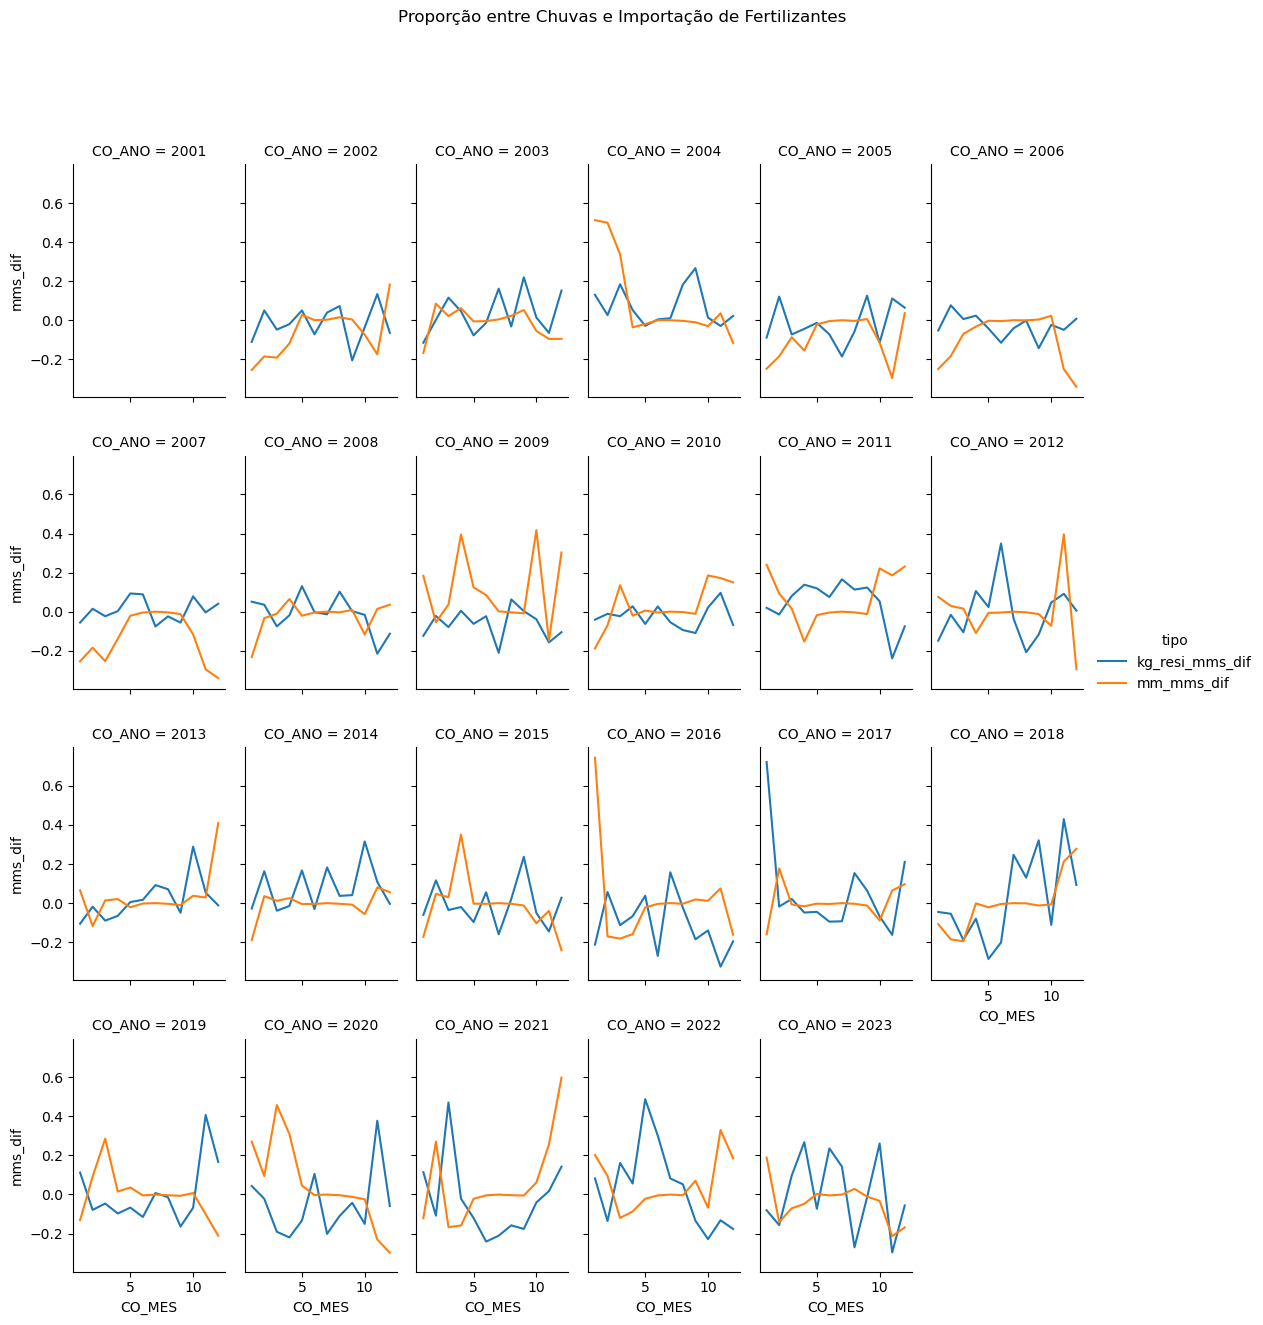

In [277]:
sns.relplot(height=3, aspect=1/1.618,kind='line',data=i_c_l,x='CO_MES',y='mms_dif',hue='tipo', col='CO_ANO',col_wrap=6).fig.suptitle("Proporção entre Chuvas e Importação de Fertilizantes",y=1.1)
plt.show()

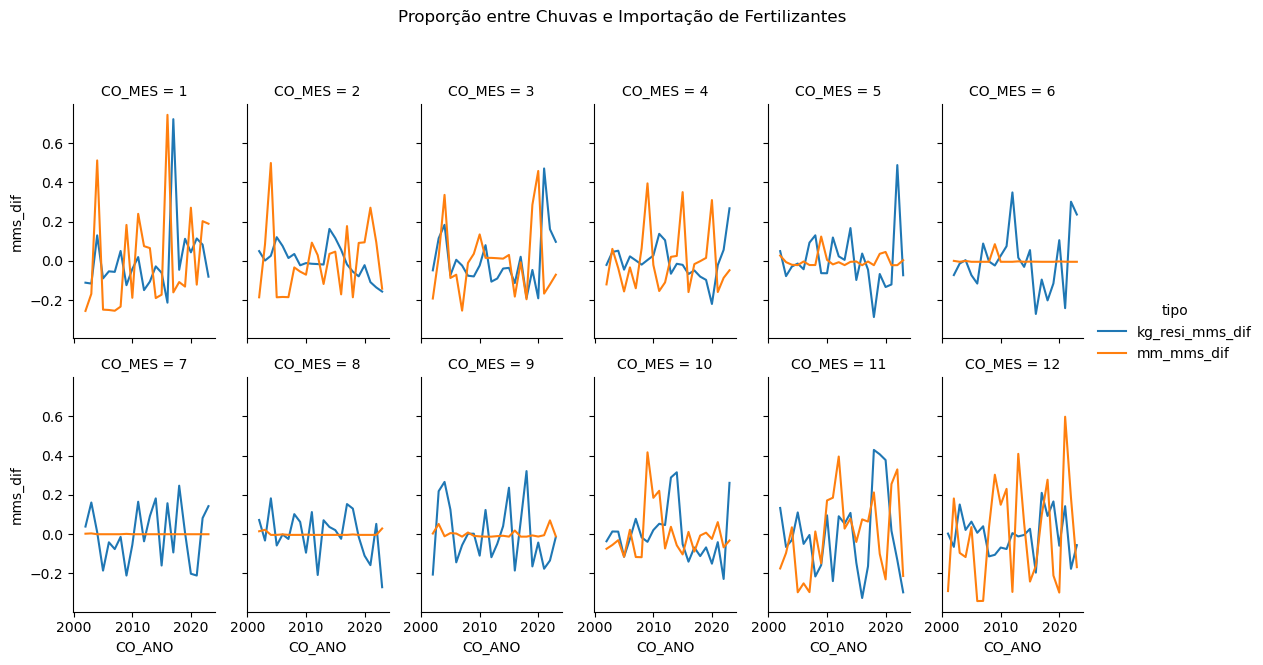

In [278]:
sns.relplot(height=3, aspect=1/1.618,kind='line',data=i_c_l,x='CO_ANO',y='mms_dif',hue='tipo', col='CO_MES',col_wrap=6).fig.suptitle("Proporção entre Chuvas e Importação de Fertilizantes",y=1.1)
plt.show()

In [279]:
i_c_l.tipo.unique()

array(['kg_resi_mms_dif', 'mm_mms_dif'], dtype=object)

In [280]:
a=i_c_l[i_c_l.tipo=='mm_mms_dif']
a.head(1)

,CO_ANO,CO_MES,date,mms_dif,tipo
0,2001,12,2001-12-01,-0.290263,mm_mms_dif


In [281]:
b=i_c_l[i_c_l.tipo!='mm_mms_dif']
b.head(1)

,CO_ANO,CO_MES,date,mms_dif,tipo
0,2001,12,2001-12-01,0.002802,kg_resi_mms_dif


In [282]:
a_ini=a.date.min()
a_fim=a.date.max()

a.CO_MES=a.CO_MES+7
for c in range(1,7+1):
    a.loc[a.CO_MES==12+c,'CO_ANO']=a.loc[a.CO_MES==12+c]['CO_ANO']+1
    a.loc[a.CO_MES==12+c,'CO_MES']=c

a=a[(a.date>=a_ini)&(a.date<=a_fim)]
b=b.merge(a[['CO_ANO','CO_MES']])
i_c_l=pd.concat([a,b])
i_c_l=i_c_l.dropna()
i_c_l.head(1)

,CO_ANO,CO_MES,date,mms_dif,tipo
0,2002,7,2001-12-01,-0.290263,mm_mms_dif


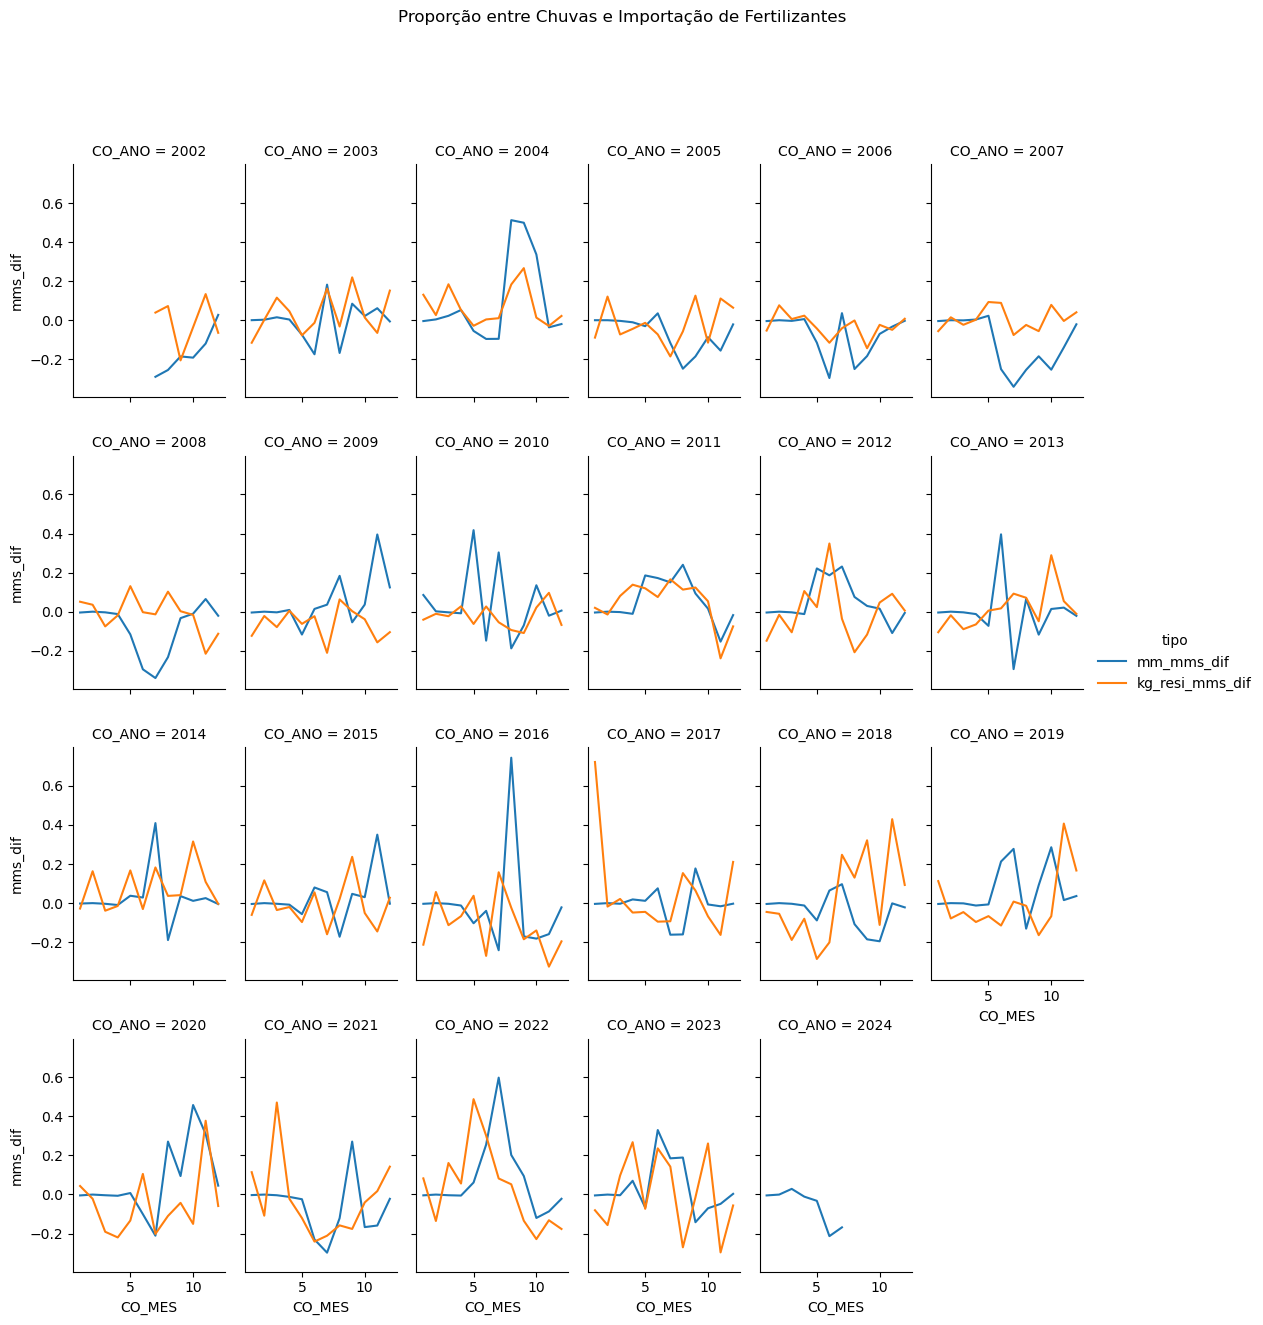

In [283]:
sns.relplot(height=3, aspect=1/1.618,kind='line',data=i_c_l,x='CO_MES',y='mms_dif',hue='tipo', col='CO_ANO',col_wrap=6,ci=None).fig.suptitle("Proporção entre Chuvas e Importação de Fertilizantes",y=1.1)
plt.show()

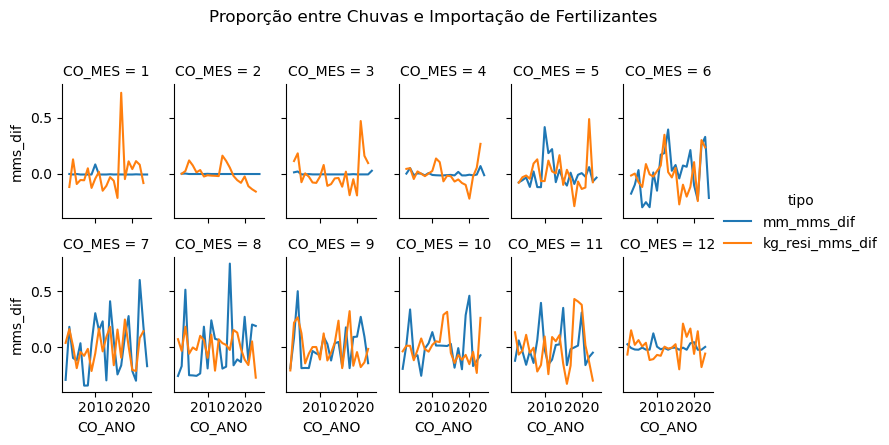

In [284]:
sns.relplot(height=2, aspect=1/1.618,kind='line',data=i_c_l,x='CO_ANO',y='mms_dif',hue='tipo', col='CO_MES',col_wrap=6,ci=None)\
.fig.suptitle("Proporção entre Chuvas e Importação de Fertilizantes",y=1.1)
plt.show()